# BB1 - System Modeling and Transfer Functions

This notebook is a **crash course in the building blocks of control theory**.  
Our goal here is not to derive everything from first principles, but to **see control concepts in action** through short code experiments.  
By the end, you should have the intuition to connect physical systems, mathematical models, and computational tools.  

We will move step by step:  
1. Start with signals and observe how systems behave in **time** and **frequency**.  
2. Build simple models (mechanical and electrical) from differential equations.  
3. Use transforms to turn those equations into **transfer functions**.  
4. Explore **poles and zeros**, and see how they explain stability and oscillations.  
5. Combine subsystems with **block diagrams** to model more complex loops.  

The emphasis is on **applications and code demonstrations**, not heavy derivations.  
Every section includes runnable Python examples so you can vary parameters and directly see the impact on system behavior.  

**<ins>Learning Objectives</ins>**  

By the end of this notebook, you should be able to:  
- Recognize basic input signals (step, impulse, sine) and interpret system responses.  
- Model simple physical systems (mass–spring–damper, RC circuit) with differential equations.  
- Apply the Laplace transform to obtain **transfer functions** from ODEs.  
- Interpret poles and zeros in terms of stability, oscillation, and response speed.  
- Use block diagram operations to reduce interconnections into a single transfer function.  
- Build the intuition needed for **feedback and control design** in the next notebook (BB2).

---

In [1]:
# Core numerical and plotting
import numpy as np
import matplotlib.pyplot as plt

# Symbolic math (Laplace/Fourier transforms, ODEs)
import sympy as sp

# Control systems (transfer functions, state-space, responses, bode/nyquist, etc.)
import control as ct

# 1 - Signals and Systems Behaviour

## 1.1 - Signals


Before we dive into mathematical tools, let’s begin with the basics:  
a **system** is anything that takes an input signal and produces an output signal.  
Our goal in control theory is to understand and predict this input–output relationship.

Some standard input signals are used as "test probes" to study system behavior:  

- **Impulse** – a sharp kick, reveals the system’s natural dynamics.  
- **Step** – a sudden change, useful for seeing settling time, overshoot, and steady-state error.
- **Ramp** – a signal that increases linearly with time. 
- **Sine wave** – allows us to explore how the system responds to different frequencies.  

By observing a system’s response to these signals, we begin to build intuition about its **time-domain** and **frequency-domain** behavior.  
This intuition is the foundation for modeling and, later, designing controllers.

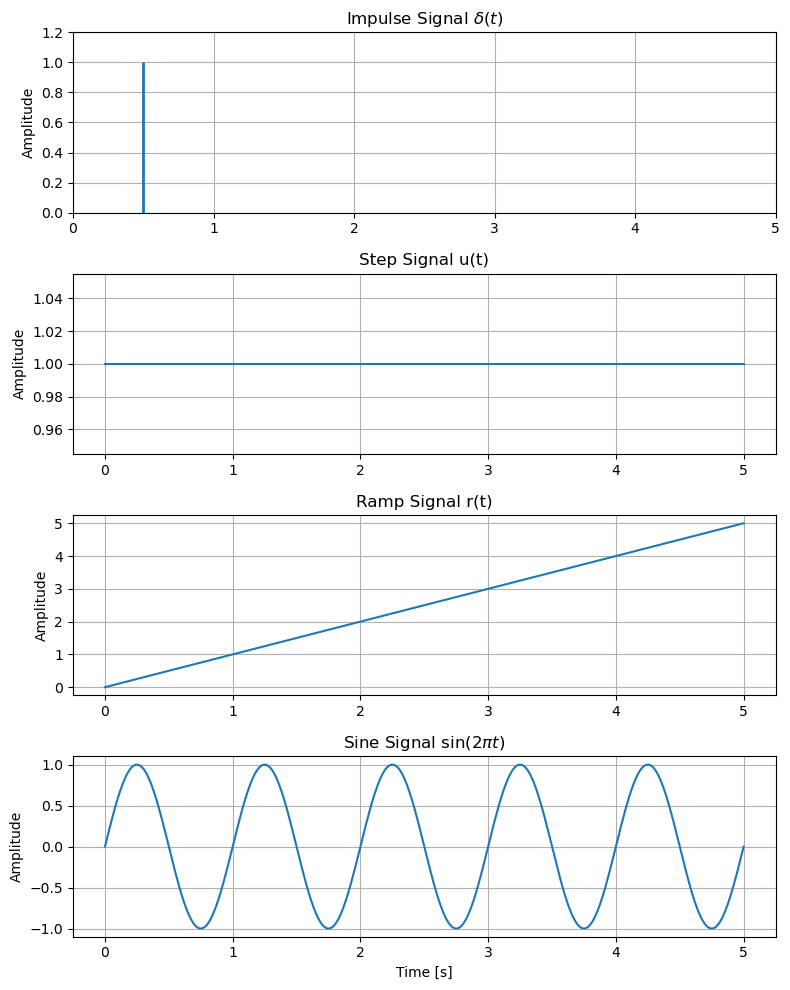

In [2]:
# Time (0-5s)
t = np.linspace(0, 5, 500)

# Step, Ramp, Sine
step = np.ones_like(t)
ramp = t
sine = np.sin(2 * np.pi * 1.0 * t)  # 1 Hz sine

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

# --- Impulse as a vertical line at t=0.5 ---
impulse_time = 0.5
impulse_amp = 1.0
axs[0].vlines(x=impulse_time, ymin=0, ymax=impulse_amp, colors="C0", linewidth=2)
axs[0].set_xlim(0, 5)
axs[0].set_ylim(0, 1.2)
axs[0].set_title(r"Impulse Signal $\delta(t)$")
axs[0].set_ylabel("Amplitude")
axs[0].grid(True)

# Step
axs[1].plot(t, step)
axs[1].set_title("Step Signal u(t)")
axs[1].set_ylabel("Amplitude")
axs[1].grid(True)

# Ramp
axs[2].plot(t, ramp)
axs[2].set_title("Ramp Signal r(t)")
axs[2].set_ylabel("Amplitude")
axs[2].grid(True)

# Sine
axs[3].plot(t, sine)
axs[3].set_title(r"Sine Signal $\sin(2\pi t)$")
axs[3].set_xlabel("Time [s]")
axs[3].set_ylabel("Amplitude")
axs[3].grid(True)

plt.tight_layout()
plt.show()

**<ins>Why these signals?</ins>**

- **Impulse**: Imagine striking a block with a hammer and then observing what happens to the block. This describes the natural dynamics of a given system.  
- **Step**: Imagine flipping a switch. This tells us how the system settles to a new state. 
- **Ramp**: Imagine taking a hammer and repeatedly striking a block. This will describe how a system reacts to repeated 'impulses' and its subsequent dynamics (maybe useful when predicting system dynamics)  
- **Sine**: Imagine shaking a strucutre at different frequencies (or modes). This will describe system dynamics over time given som oscillatory inputs to better determine failure modes, it is more useful in the analysis of structures (aeroelasticity, strucutural dynamics etc...) 

## 1.2 - System Behaviour

Now that we have defined the standard test signals (impulse, step, ramp, sine), 
let’s apply them to a simple **first-order system**:

$$
G(s) = \frac{1}{s+1}
$$

This system could represent an RC circuit or a basic thermal system.  
By observing its responses, we can start to see how different inputs highlight different aspects of system behavior.  

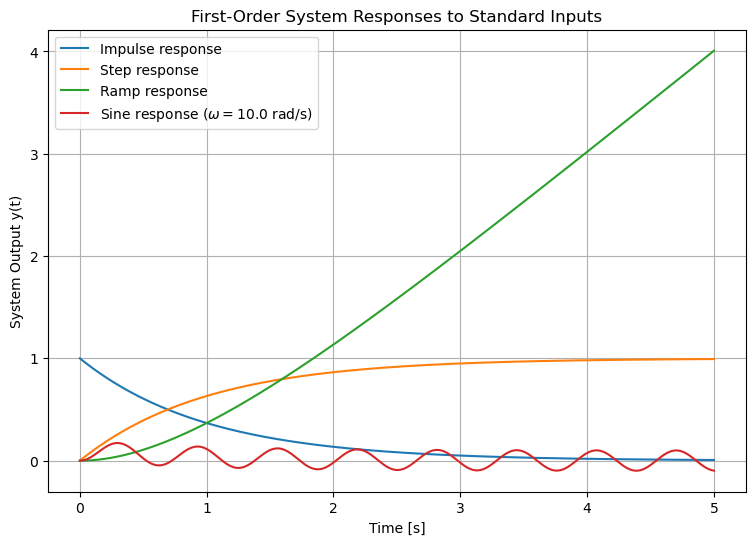

In [3]:
s = ct.tf("s")
G = 1 / (s + 1)   # simple first-order system

# Time 
t = np.linspace(0, 5, 500)

# Inputs
ramp = t
omega = 10.0                      # rad/s (change this to feel the effect)
u_sine = np.sin(omega * t)       # sine input u(t) = sin(omega * t)

# System responses
t_imp, y_imp = ct.impulse_response(G, T=t)
t_step, y_step = ct.step_response(G, T=t)
t_ramp, y_ramp = ct.forced_response(G, T=t, U=ramp)
t_sin,  y_sin  = ct.forced_response(G, T=t, U=u_sine)

# Plot
plt.figure(figsize=(9,6))
plt.plot(t_imp, y_imp, label="Impulse response")
plt.plot(t_step, y_step, label="Step response")
plt.plot(t_ramp, y_ramp, label="Ramp response")
plt.plot(t_sin,  y_sin,  label=rf"Sine response ($\omega={omega}$ rad/s)")
plt.legend()
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("System Output y(t)")
plt.title("First-Order System Responses to Standard Inputs")
plt.show()


- **Impulse response**: Just like the hammer strike analogy, the system is “kicked” once and we watch how it naturally reacts.  
  In this first-order example, the response decays exponentially to zero — showing the system’s inherent stability.  

- **Step response**: Like flipping a switch, the input suddenly jumps and then holds steady.  
  The system output smoothly rises to the new steady-state value (here $y=1$) without overshoot, which is typical of a first-order system.  

- **Ramp response**: Unlike the hammer analogy of repeated strikes, a ramp is more like a steadily increasing push.  
  The system cannot keep up with the continually rising input, and we see the output falling further and further behind — the **steady-state error grows with time**.  

- **Sine response**: Similar to shaking a structure at a fixed frequency.  
  At low frequencies the output would closely track the input, but here at $\omega = 10 \,\text{rad/s}$ the response is clearly attenuated and lags behind.  
  This hints at the system’s **frequency-dependent behavior**, which we will formalize later using Bode plots.  


Together, these responses confirm that each standard input excites a different aspect of system behavior:  
- **Impulse** → natural dynamics  
- **Step** → transient and steady-state behavior  
- **Ramp** → tracking limitations  
- **Sine** → frequency sensitivity

| **Input Signal $u(t)$** | **Analogy**                         | **System Response $y(t)$ (conceptual)** | **What it Reveals**                          | **Engineering Use** |
|--------------------------|--------------------------------------|------------------------------------------|-----------------------------------------------|----------------------|
| **Impulse** $\delta(t)$ | Hammer strike on a block            | Natural response (decaying modes, resonance if present) | Natural dynamics, modes, stability | Impulse response = system “fingerprint” |
| **Step** $u(t)$         | Flipping a switch / sudden force    | Transient + steady-state output          | How system settles to a new equilibrium        | Rise time, overshoot, settling, steady-state error |
| **Ramp** $r(t)=t$       | Steadily increasing push on a block (or equivalently, the cumulative effect of impulses) | Output lags, steady-state error grows | Tracking ability under continuously growing input | Steady-state error (Type number test) |
| **Sine** $\sin(\omega t)$ | Shaking a structure at frequencies  | Steady oscillation with reduced amplitude and phase lag | Frequency-dependent behavior                  | Frequency response, resonance, bandwidth |

This sets the stage for **Chapter 2**, where we will learn how to build mathematical models of physical systems using well-known principles of physics. With these models, we can define the system dynamics and then analytically predict how the system will respond to different types of inputs.

# 2 - Modeling Physical Systems

In Chapter 1 we saw how systems respond to standard test inputs such as impulses, steps, ramps, and sinusoids. But to predict these responses analytically, we need a **mathematical model** of the system.

In this chapter we will learn how to model physical systems by applying **well-known principles of physics** (Newton’s laws for mechanics, Kirchhoff’s laws for electrical circuits, etc.) to derive **differential equations** that describe their dynamics. These equations form the foundation for transfer functions, which we will develop further in Chapter 3.

## 2.1 - Mechanical Systems

A classic example of a mechanical system is the **mass–spring–damper** system. It models situations where a body experiences inertia (mass), elastic restoring force (spring), and energy dissipation (damper).

Using Newton’s second law ($F = ma$):

$$
M \ddot{x}(t) + B \dot{x}(t) + K x(t) = F(t)
$$

where:  
- $M$ = mass (kg)  
- $B$ = damping coefficient (N·s/m)  
- $K$ = spring constant (N/m)  
- $F(t)$ = applied force (N)  
- $x(t)$ = displacement (m)  

This is a **second-order ordinary differential equation (ODE)**. It describes how the displacement $x(t)$ evolves in response to a force input $F(t)$.

**Key Insight:**  
- The system’s order equals the number of energy storage elements (here: mass and spring → 2nd order).  
- Damping $B$ determines whether the system oscillates, and how quickly it settles.

## 2.2 - Electrical Systems

An electrical analogy is the **RC circuit**, consisting of a resistor $R$ and a capacitor $C$ in series with an input voltage $v_{in}(t)$.

Applying Kirchhoff’s Voltage Law (KVL):

$$
v_{in}(t) = v_R(t) + v_C(t)
$$

where:  
- $v_R(t) = R i(t)$  
- $v_C(t) = \frac{1}{C} \int i(t) \, dt$  

Expressing in terms of capacitor voltage $v_C(t)$, and noting that $i(t) = C \dot{v}_C(t)$:

$$
RC \, \dot{v}_C(t) + v_C(t) = v_{in}(t)
$$

This is a **first-order ODE**, describing how the capacitor voltage responds to an input voltage.

**Key Insight:**  
- The system’s order equals the number of independent energy storage elements (here: one capacitor → 1st order).  
- The time constant $\tau = RC$ sets the response speed: larger $\tau$ = slower charging/discharging.

## 2.3 - System Order and Energy Storage

The **order** of a system is equal to the number of independent energy storage elements in the model.  

- **RC Circuit** → 1 capacitor → **1st-order system**  
- **Mass–Spring–Damper** → 1 mass + 1 spring → **2nd-order system**  

**Key idea:**  
- Each storage element contributes a derivative in the ODE.  
- More storage elements → higher-order differential equation.  

## 2.4 - Mechanical-Electrical Analogies

Mechanical and electrical systems often share the same mathematical form. This allows engineers to apply the same tools across different domains.

| Mechanical Quantity | Electrical Quantity |
|----------------------|----------------------|
| Force $F$           | Voltage $v$          |
| Velocity $\dot{x}$  | Current $i$          |
| Mass $M$            | Inductor $L$         |
| Spring constant $K$ | Capacitor $C$        |
| Damper $B$          | Resistor $R$         |

This analogy highlights that **different physics can yield the same mathematics**,  
so once we learn how to analyze one type of system, we can apply the method to many others.

## 2.5 - General Modeling Recipe


To model any physical system:

1. **Identify energy storage elements** (mass, spring, capacitor, inductor, etc.).  
2. **Apply physical laws** (Newton’s laws, Kirchhoff’s laws, conservation principles).  
3. **Formulate the ODE(s)** that describe system dynamics.  
4. **Determine the system order** from the number of storage elements.  
5. Later, we will learn to **convert ODEs → transfer functions** to make analysis easier.


These steps complete our introduction to modeling. Next, in **Chapter 3**, we will use transforms to turn these differential equations into algebraic transfer functions, making it possible to analyze and predict system responses efficiently.
For complicated systems, we will also employ the use of block diagrams, a visual representative to modeling system dynamics that also supports in the development and simplification of transfer functions.

# 3 - Transforms, Transfer Functions and Block Diagrams

## 3.1 - Fourier Series

- With **Taylor/Maclaurin series**, we represent complicated functions as a sum of simple **polynomial terms**:
  $$
  f(x) \approx a_0 + a_1x + a_2x^2 + \dots
  $$
  This works well for smooth functions near a point.

- For **periodic functions**, polynomials are not the natural building blocks.  
  Instead, the natural building blocks are **sinusoids** (sines and cosines).

- The central idea: *any periodic signal, no matter how irregular, can be expressed as a sum of sinusoids at integer multiples of a fundamental frequency*:
  $$
  x(t) = a_0 + \sum_{n=1}^\infty \big[ a_n \cos(n\omega_0 t) + b_n \sin(n\omega_0 t) \big], 
  \quad \omega_0 = \frac{2\pi}{T}.
  $$

- These sinusoids act as a **basis** (just like polynomial powers in a Taylor series).  
  By adjusting their coefficients, we can represent complicated periodic waveforms.

**Key takeaway:**  
Fourier Series decompose a periodic function into its “ingredients”: simple sinusoids at harmonically related frequencies.  
This is not just approximation. For well-behaved signals, it is an exact representation.

**<ins>Demo</ins>**

We will end this section with a small demo. In this demo we will:

- **Target signal**: a square wave of amplitude $A$ and period $T=\tfrac{1}{f_0}$.  
- **Fourier series partial sum**:  
  $$
  S_N(t) = \sum_{n\in\{1,3,5,\dots\}} \frac{4A}{\pi n}\,\sin(n\omega_0 t).
  $$

- **Plots**:  
  1. **Time domain** — the partial sum $S_N(t)$ converging to the square wave.  
  2. **Frequency domain** — discrete spikes at $f_n = n f_0$ with heights $b_n = \tfrac{4A}{\pi n}$.


**Why only odd harmonics?**  
- A 50% duty square wave is **odd symmetric** about the origin.  
- Symmetry rules in Fourier analysis:  
  - **Odd symmetry** $\;\Rightarrow\;$ only **sine terms** survive.  
  - **Even harmonics** cancel out due to this symmetry.  
- Hence, only odd sine terms remain in the expansion.


**What to look for**
- The **fundamental** ($n=1$) defines the main oscillation.  
- Higher **odd harmonics** sharpen the edges and flatten the tops.  
- The **spectrum** is a line spectrum at harmonics of $f_0$; amplitudes decay as $1/n$.

**Transition to Fourier Transform**  
As $T$ increases ($f_0$ decreases), the harmonic lines get closer together.  
In the limit $T \to \infty$, these discrete lines merge into a **continuous spectrum** — the Fourier Transform.

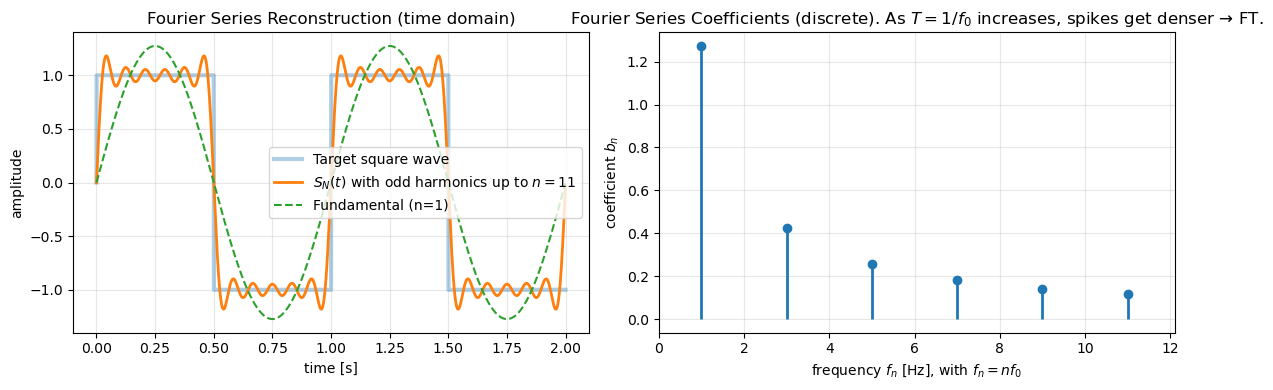

In [7]:
# Parameters (tweak these)
# -----------------------------
A = 1.0        # square-wave amplitude (+A and -A)
f0 = 1.0      # fundamental frequency [Hz]
N_odd = 11     # number of odd harmonics to include (use an odd number: 1,3,5,...,N_odd)

# Time base
T0 = 1.0 / f0                                           # Period
t = np.linspace(0, 2*T0, 3000, endpoint=False)          # evenly spaced time samples
w0 = 2 * np.pi * f0                                     # angular frequency (rad/s)

# Target square wave of amplitude A
x_square = A * np.sign(np.sin(w0 * t))

# Build odd-harmonic components and partial sum S_N(t)
odd_ns = np.arange(1, N_odd+1, 2)                       # 1,3,5,...,N_odd
coeff  = (4*A/np.pi) * (1.0/odd_ns)                     # b_n = 4A/(pi*n) for odd n

S = np.zeros_like(t)
components = []
for n, bn in zip(odd_ns, coeff):
    comp = bn * np.sin(n*w0*t)
    components.append((n, comp))
    S += comp

# -----------------------------
# Figure: Time reconstruction + Spectrum
# -----------------------------
fig, (ax_time, ax_spec) = plt.subplots(1, 2, figsize=(12, 4))

# --- Left-side Plot: time-domain reconstruction ---
ax_time.plot(t, x_square, linewidth=3, alpha=0.35, label="Target square wave")
ax_time.plot(t, S, linewidth=2, label=rf"$S_N(t)$ with odd harmonics up to $n={odd_ns[-1]}$")
# also draw first harmonic alone to show dominance
ax_time.plot(t, components[0][1], linestyle="--", linewidth=1.5, label="Fundamental (n=1)")
ax_time.set_xlabel("time [s]")
ax_time.set_ylabel("amplitude")
ax_time.set_title("Fourier Series Reconstruction (time domain)")
ax_time.grid(True, alpha=0.3)
ax_time.legend(loc="best")

# --- Right-side plot: discrete spectrum (spikes at n f0, heights = coefficients) ---
f_spikes = odd_ns * f0
ax_spec.vlines(f_spikes, 0, coeff, linewidth=2)
ax_spec.plot(f_spikes, coeff, "o")  # caps
ax_spec.set_xlabel(r"frequency $f_n$ [Hz], with $f_n = n f_0$")
ax_spec.set_ylabel(r"coefficient $b_n$")
ax_spec.set_title("Fourier Series Coefficients (discrete). As $T=1/f_0$ increases, spikes get denser → FT.")
ax_spec.grid(True, alpha=0.3)
ax_spec.set_xlim(0, f_spikes[-1] * 1.1)


plt.tight_layout()
plt.show()


**Time-domain panel (left).**  
- The orange curve $S_N(t)$ is the sum of a few sinusoids at $n\omega_0$.  
- As we include more odd harmonics, $S_N(t)$ **converges** to the blue square wave (note the small ripples near jumps: this is the **Gibbs phenomenon**).

**Frequency-domain panel (right).**  
- Each spike is a **harmonic** at $f_n = n f_0$; only **odd** $n$ appear for this square wave.  
- The spike heights follow $b_n=\tfrac{4A}{\pi n}$, so the fundamental dominates, and higher harmonics shrink like $1/n$.

**Key idea to carry into 3.2 (Fourier Transform).**  
- For **periodic** signals, the spectrum is **discrete** (spikes at integer multiples of $f_0$).  
- If we make the period larger ($T \uparrow \;\Rightarrow\; f_0 \downarrow$), the spikes move **closer together**.  
- In the limit $T\to\infty$ (signal becomes **non-periodic**), those discrete lines become a **continuous spectrum**.  
  That continuous-frequency description is exactly the **Fourier Transform**.

## 3.2 - Fourier Transform

In Chapter 2, we saw that physical modeling leads to differential equations.  
Solving these directly can be tedious, especially for complex inputs.  

The **Fourier transform** provides a powerful perspective:  
every signal can be thought of as a combination of sinusoids of different frequencies.  
The transform tells us *how much of each sinusoid is present* in a signal.  

Mathematically, for a signal $x(t)$:

$$
X(j\omega) = \int_{-\infty}^{\infty} x(t) \, e^{-j\omega t} \, dt
$$

- $x(t)$ is the time-domain signal.  
- $X(j\omega)$ describes the frequency content of $x(t)$.  
- The magnitude $|X(j\omega)|$ tells us how strong each frequency component is.  
- The angle $\angle X(j\omega)$ tells us the phase shift of those components.  

**Interpretation:**  
- A pure sine wave at frequency $\omega_0$ → spectrum has a spike at $\omega_0$.  
- A square wave → spectrum shows many sinusoidal harmonics.  

**Limitation:** Fourier analysis works beautifully for signals that are purely oscillatory and exist for all time.  
But it struggles with signals that **decay, grow, or only exist for $t \geq 0$**.  
This motivates the use of the **Laplace transform**, which generalizes Fourier by including exponential terms. 

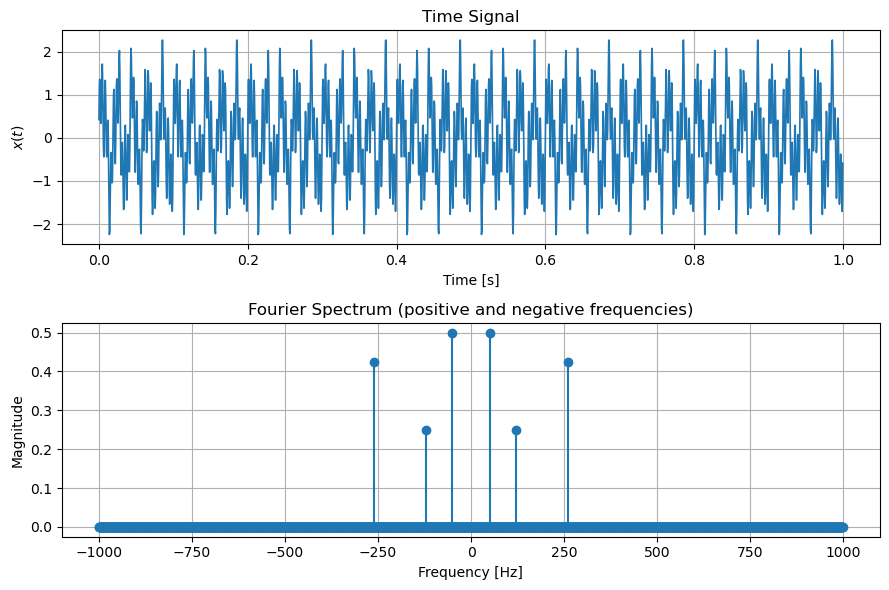

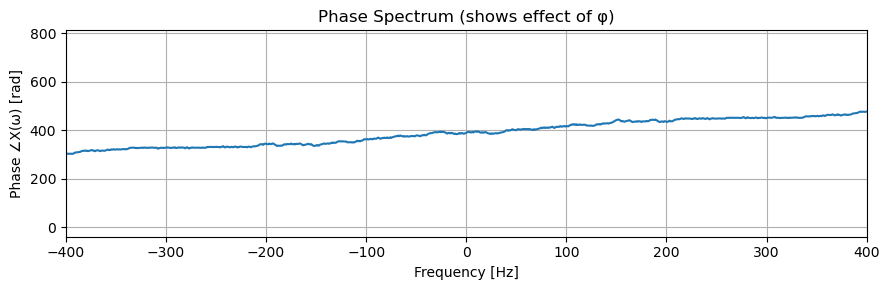

In [5]:
# -----------------------------
# Simple Fourier Transform intuition demo
# -----------------------------


# -----------------------------
# Config: any number of sinusoids
# -----------------------------
fs   = 2000.0                 # samples per second
T    = 1.0                    # duration [s]
freqs = [50, 120, 260]        # frequencies [Hz]
amps  = [1.0, 0.5, 0.85]      # amplitudes
phs   = [0.0, 0.0, np.pi/6]   # phases [rad]

# -----------------------------
# Build time signal
# -----------------------------
t = np.arange(0, T, 1/fs)
x = np.zeros_like(t)
for f0, A0, phi0 in zip(freqs, amps, phs):
    x += A0 * np.sin((2 * np.pi * f0 * t) + phi0)

# --------------------------------
# FFT
# --------------------------------
N = len(t)                          # number of samples
X = np.fft.fft(x) / N               # compute FFT and normalize
f = np.fft.fftfreq(N, d=1/fs)       # frequency values (Hz)

# Shift so zero is in the center
X_shifted = np.fft.fftshift(X)
f_shifted = np.fft.fftshift(f)

# --------------------------------
# Plots
# --------------------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))

# Time signal
ax1.plot(t, x, lw=1.2)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("$x(t)$")
ax1.set_title("Time Signal")
ax1.grid(True)

# Frequency spectrum (both + and – frequencies)
ax2.stem(f_shifted, np.abs(X_shifted), basefmt=" ")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Magnitude")
ax2.set_title("Fourier Spectrum (positive and negative frequencies)")
ax2.grid(True)

plt.tight_layout()
plt.show()

# OPTIONAL: simple phase plot at the end (unwrap for readability)
fig, axp = plt.subplots(1, 1, figsize=(9, 3))
phase = np.unwrap(np.angle(X_shifted))
axp.plot(f_shifted, phase)
axp.set_xlim(-400, 400)  # zoom near your spikes if you like
axp.set_xlabel("Frequency [Hz]")
axp.set_ylabel("Phase ∠X(ω) [rad]")
axp.set_title("Phase Spectrum (shows effect of φ)")
axp.grid(True)
plt.tight_layout()
plt.show()


**<ins>Note</ins>**

1. **Why `np.fft.fft(x)` looks redundant**

   - In NumPy, `fft` is not a single function but a **submodule**.  
   - Inside that submodule lives the actual Fast Fourier Transform routine called `fft()`.  
   - So when we write `np.fft.fft(x)`, we are saying:  
     > "From NumPy (`np`), go into the `fft` module, and call its function `fft`."  
   - This is the same style as `np.linalg.inv()` for matrix inversion or `np.random.rand()` for random numbers.

<br>

2. **What in the world is a negative frequency?**

   The FFT is based on **complex exponentials**:

   $$
   e^{j\omega t} = \cos(\omega t) + j \sin(\omega t).
   $$

   A cosine is actually made from **two exponentials**:

   $$
   \cos(\omega t) = \tfrac{1}{2}\big(e^{j\omega t} + e^{-j\omega t}\big).
   $$

   - The first term, $e^{j\omega t}$, shows up at **positive frequency** $+\omega$.  
   - The second term, $e^{-j\omega t}$, shows up at **negative frequency** $-\omega$.  

   This is why when you Fourier transform a real signal, every positive frequency spike has a **matching negative spike**.  
   Negative frequencies are not “physical signals spinning backwards in time” — they are the **mirror components** required by the math to keep the signal real in the time domain.

   **Key takeaways from the spectrum plot:**

   - Every positive frequency spike (e.g. $+50$ Hz, $+120$ Hz, $+260$ Hz) has a matching negative spike ($-50$ Hz, $-120$ Hz, $-260$ Hz).  
   - This symmetry is guaranteed whenever the time signal is **real**.  
   - If we only care about the physical frequencies, we usually just look at the **positive half** of the spectrum.  
   - The spike heights correspond to the amplitudes of the sinusoids in the signal (after proper normalization).


## 3.2 - Laplace Transform

## 3.3 - From Differential Equations to Transfer Functions

## 3.4 - Block Diagrams as System Representation

## 3.5 - Summary

# 4 - Poles, Zeros and Stability

# 5 - Block Diagrams and System Composition